In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from matplotlib.pylab import plt
import warnings

from torchmetrics.classification import BinaryAccuracy
import os
import shutil
from util_FPC import EarlyStopping
from load_data_conventional import *
from dataloader_conventional import *
from train_model_conventional import *
from model_conventional import *


warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/dmittal/.conda/envs/RUL_Prediction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-19 12:37:08.687089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
discharge_capacities = np.load(r"./Datasets/discharge_capacity.npy", allow_pickle=True)
discharge_capacities = discharge_capacities.tolist()
percentage = 0.40

np.array(discharge_capacities[0]).shape

(7, 1851)

In [3]:
max_length_train,max_length_out = get_lengths(discharge_capacities,percentage)
max_length_out = max_length_out+1

Cell with Maximum length : 2
Maximum cycle length : 2236
Maximum Length for training X: 894
Maximum Length of output     : 1342


In [4]:

channels = [0,1,2,3,4,5,6]

Text(0, 0.5, 'Discharge Capacity')

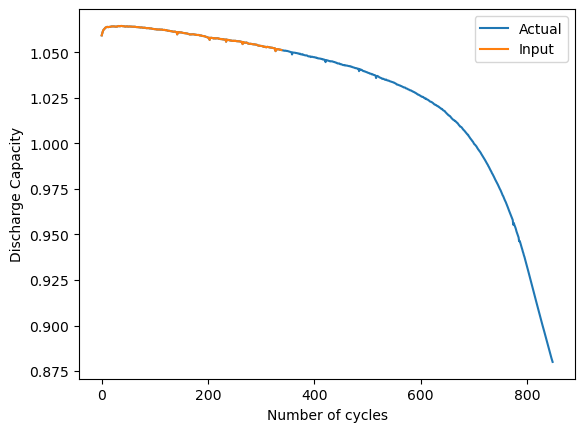

In [5]:
ind = 109

plt.plot(discharge_capacities[ind][0])
# plt.plot(X_train_padded[ind])
plt.plot(discharge_capacities[ind][0][0:int(0.4*len(discharge_capacities[ind][0]))])

# if(ind != cell_with_max_cycle_life):
#     plt.plot(np.pad(Y_train_padded[ind],(list(X_train_padded[ind][0]).index(-0.1),0),constant_values=(-1)))
    
# else:
#     plt.plot(np.pad(Y_train_padded[ind],(len(X_train_padded[ind][0]),0),constant_values=(-1)))

plt.legend(['Actual', 'Input', 'Output'])
# plt.title("Input and Output Data")
plt.xlabel("Number of cycles")
plt.ylabel("Discharge Capacity")

In [6]:
# model = LSTM_Model_Conventional(max_length_train,len(channels),max_length_out)
model = CNN_Model_Conventional(max_length_train,len(channels),max_length_out)
ch = ''.join(map(str,channels))
dataset = "MIT"
version = 1
fld = 1

model_dir = "./Weights/Conventional/"
model_path = f'{model_dir}/{dataset}_{model.name}_Conventional_Channels={ch}_Version={version}_Fold{fld}.pth'
epochs = 50
load_pretrained = False
pretrained = True
lr = 0.001
n_folds = 5
parameters = {"epochs" : epochs,
                "learning_rate" : lr ,
                "percentage" : percentage,
                "max_length_train" :max_length_train,
                "max_length_out" :max_length_out,
                "channels" : channels
}

optimizer = torch.optim.Adam(model.parameters(), lr = lr, betas= (0.9, 0.99))
criterion = nn.MSELoss()
early_stopping_patiance = 25


if(pretrained):
    model.load_state_dict(torch.load(model_path,map_location= device))
else:
    if(load_pretrained):
       model.load_state_dict(torch.load(model_path,map_location= device))

       model= perform_n_folds_conventional(model, n_folds,discharge_capacities, criterion, 
                    optimizer, early_stopping_patiance, model_path,
                    parameters,version, dataset)
    else:
        model = perform_n_folds_conventional(model, n_folds,discharge_capacities, criterion, 
                    optimizer, early_stopping_patiance, model_path,
                    parameters,version, dataset)




In [7]:
dataset = "MIT"
m_name = "CNN"

if(m_name =="LSTM"):
    model = LSTM_Model_Conventional(max_length_train,len(channels),max_length_out)
else:
    model = CNN_Model_Conventional(max_length_train,len(channels),max_length_out)

for fold in range(5):
    model_dir = "./Weights/Conventional/"
    model_path = f'{model_dir}/{dataset}_{model.name}_Conventional_Channels={ch}_Version={version}_Fold{fold}.pth'
    model.load_state_dict(torch.load(model_path,map_location= device))

    test_batteries_temp = np.load(f"Test_data/test_batteries_Conventional_{dataset}_{model.name}_fold"+str(fold)+"_version" +str(version) +".npy",allow_pickle=True)
    data_test_temp =  get_data_conventional(discharge_capacities, channels,test_batteries_temp,max_length_train, max_length_out,percentage)
    obj_test_temp  = battery_dataloader_conventional(data_test_temp)
    test_dataloader_temp = DataLoader(obj_test_temp, batch_size=1,shuffle=False)

    _,_,_, outputs = test_model_conventional(model, criterion, test_dataloader_temp, True)



Test loss : MSE = 0.024724419728154316, MAE = 0.0790953729301691, MAPE = 0.2647590909898281 




Test loss : MSE = 0.008765001622959971, MAE = 0.054683484956622126, MAPE = 0.15185286939144135 




Test loss : MSE = 0.006597253942745737, MAE = 0.04350979652255774, MAPE = 0.11722975566983224 




Test loss : MSE = 0.004153764217626303, MAE = 0.045405224785208705, MAPE = 0.14487079173326492 




Test loss : MSE = 0.0033684959222834245, MAE = 0.03890206726888815, MAPE = 0.09910789395992954 




In [8]:

# MIT Dataset
LSTM_MSE = [0.023542139900964685,0.0017156877589877696, 0.0017156877589877696, 0.0028332607203628867 ,0.0036076902336693215]
LSTM_MAE = [0.06665833201259375,0.030355808362364768 ,0.02538919050246477 , 0.03636148951947689 , 0.09542944595217705]
LSTM_MAPE = [0.2039700385928154, 0.09131751447916031 , 0.0947448255121708,0.03928086122808357 , 0.1453689782259365] 



print("LSTM Average MAE = {}, MSE = {} , MAPE = {}".format(np.mean(LSTM_MAE), np.mean(LSTM_MSE), np.mean(LSTM_MAPE)))
print("LSTM STD     MAE = {}, MSE = {} , MAPE = {}".format(np.std(LSTM_MAE), np.std(LSTM_MSE), np.std(LSTM_MAPE)))

CNN_MSE = [0.024724419728154316,0.008765001622959971, 0.006597253942745737, 0.004153764217626303 ,0.0033684959222834245]
CNN_MAE = [0.0790953729301691,0.054683484956622126 ,0.04350979652255774 , 0.045405224785208705 , 0.03890206726888815]
CNN_MAPE = [0.2647590909898281 ,0.15185286939144135  ,0.11722975566983224,0.14487079173326492, 0.09910789395992954 ] 

print("CNN Average MAE = {}, MSE = {} , MAPE = {}".format(np.mean(CNN_MAE), np.mean(CNN_MSE), np.mean(CNN_MAPE)))
print("CNN STD     MAE = {}, MSE = {} , MAPE = {}".format(np.std(CNN_MAE), np.std(CNN_MSE), np.std(CNN_MAPE)))

# HUST

LSTM Average MAE = 0.050838853269815444, MSE = 0.0066828932745944866 , MAPE = 0.1149364436076333
LSTM STD     MAE = 0.026515698701975128, MSE = 0.008459988210663625 , MAPE = 0.055753820674384884
CNN Average MAE = 0.05231918929268916, MSE = 0.009521787086753952 , MAPE = 0.15556408034885924
CNN STD     MAE = 0.014338628761253639, MSE = 0.007834849318987733 , MAPE = 0.05780742389563262


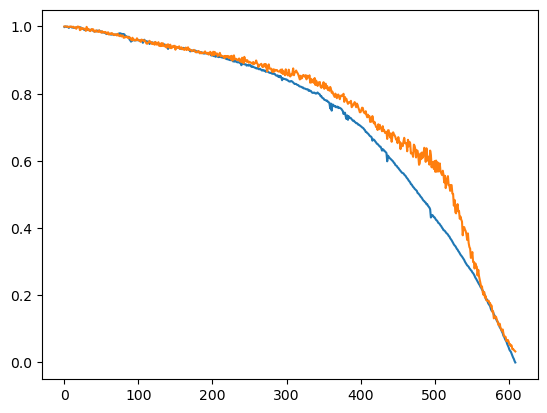

In [9]:
plt.plot(outputs[3][0].detach().numpy())
plt.plot(outputs[3][1].detach().numpy())



In [10]:
from load_data import get_discharge_capacities_HUST

dataset = "HUST"
channels_HUST = [0,1,2,3,4]
ch_HUST = ''.join(map(str,channels_HUST))
m_name = "LSTM"
max_length_train = 1072
max_length_out =1609
discharge_capacities_HUST = get_discharge_capacities_HUST(fea_num=1)
if(m_name =="LSTM"):
    model = LSTM_Model_Conventional(max_length_train,len(channels_HUST),max_length_out)
else:
    model = CNN_Model_Conventional(max_length_train,len(channels_HUST),max_length_out)

for fold in range(5):
    model_dir = "./Weights/Conventional/"
    model_path = f'{model_dir}/{dataset}_{model.name}_Conventional_Channels={ch_HUST}_Version={version}_Fold{fold}.pth'
    print(model_path)
    model.load_state_dict(torch.load(model_path,map_location= device))

    test_batteries_temp = np.load(f"Test_data/test_batteries_Conventional_{dataset}_{model.name}_fold"+str(fold)+"_version" +str(version) +".npy",allow_pickle=True)
    data_test_temp =  get_data_conventional(discharge_capacities_HUST, channels_HUST,test_batteries_temp,max_length_train, max_length_out,percentage)
    obj_test_temp  = battery_dataloader_conventional(data_test_temp)
    test_dataloader_temp = DataLoader(obj_test_temp, batch_size=1,shuffle=False)

    _,_,_, outputs = test_model_conventional(model, criterion, test_dataloader_temp, True)

./Weights/Conventional//HUST_LSTM_Conventional_Channels=01234_Version=1_Fold0.pth


Test loss : MSE = 0.0007548112607764779, MAE = 0.020027094171382487, MAPE = 0.10575191117823124 


./Weights/Conventional//HUST_LSTM_Conventional_Channels=01234_Version=1_Fold1.pth


Test loss : MSE = 0.00043534286533031263, MAE = 0.015909870009636506, MAPE = 0.06843494460918009 


./Weights/Conventional//HUST_LSTM_Conventional_Channels=01234_Version=1_Fold2.pth


Test loss : MSE = 0.0005963728937786073, MAE = 0.01779366601258516, MAPE = 0.06602350051204363 


./Weights/Conventional//HUST_LSTM_Conventional_Channels=01234_Version=1_Fold3.pth


Test loss : MSE = 0.0006362798453968328, MAE = 0.01903642937541008, MAPE = 0.0872241698205471 


./Weights/Conventional//HUST_LSTM_Conventional_Channels=01234_Version=1_Fold4.pth


Test loss : MSE = 0.0006865931636032958, MAE = 0.01868041291212042, MAPE = 0.07086296280225118 




In [11]:
# HUST Dataset
LSTM_MSE = [0.0007548112607764779,0.00043534286533031263,0.0005963728937786073,0.0006362798453968328,0.0006865931636032958]
LSTM_MAE = [0.020027094171382487,0.015909870009636506,0.01779366601258516 , 0.01903642937541008 , 0.01868041291212042]
LSTM_MAPE = [0.10575191117823124 , 0.06843494460918009 , 0.06602350051204363, 0.0872241698205471  , 0.07086296280225118 ] 

print("LSTM Average MAE = {}, MSE = {} , MAPE = {}".format(np.mean(LSTM_MAE), np.mean(LSTM_MSE), np.mean(LSTM_MAPE)))
print("LSTM STD     MAE = {}, MSE = {} , MAPE = {}".format(np.std(LSTM_MAE), np.std(LSTM_MSE), np.std(LSTM_MAPE)))

CNN_MSE = [0.0007958157320899772,0.0016346547363355057, 0.0012435437335322301, 0.0006841693141420061 ,0.0013803984746724987]
CNN_MAE = [0.019710673368535936,0.026245495420880616,0.02697337530553341 , 0.018532139683763185 , 0.02778300972034534]
CNN_MAPE =  [0.08083391236141324 , 0.07988402177579701 , 0.09780132373174032,0.06985098694761595 , 0.08174053877592087]

print("CNN Average MAE = {}, MSE = {} , MAPE = {}".format(np.mean(CNN_MAE), np.mean(CNN_MSE), np.mean(CNN_MAPE)))
print("CNN STD     MAE = {}, MSE = {} , MAPE = {}".format(np.std(CNN_MAE), np.std(CNN_MSE), np.std(CNN_MAPE)))

LSTM Average MAE = 0.01828949449622693, MSE = 0.0006218800057771054 , MAPE = 0.07965949778445065
LSTM STD     MAE = 0.0013884120523171032, MSE = 0.00010724978718970952 , MAPE = 0.015015647458676349
CNN Average MAE = 0.023848938699811698, MSE = 0.0011477163981544437 , MAPE = 0.08202215671849747
CNN STD     MAE = 0.00390835245964768, MSE = 0.000357531187451373 , MAPE = 0.008979781061633425


In [13]:
from load_data import get_discharge_capacities_HUST,get_discharge_capacities_MIT

dataset = "Combined"
channels_combined = [0]
ch_combined = ''.join(map(str,channels_combined))
m_name = "CNN"
max_length_train = 1072
max_length_out =1609

discharge_capacities_MIT = get_discharge_capacities_MIT()
discharge_capacities_HUST = get_discharge_capacities_HUST(fea_num=1)
discharge_capacities = discharge_capacities_MIT[0:100] + discharge_capacities_HUST[0:70] + discharge_capacities_MIT[100:] + discharge_capacities_HUST[70:]

if(m_name =="LSTM"):
    model = LSTM_Model_Conventional(max_length_train,len(channels_combined),max_length_out)
else:
    model = CNN_Model_Conventional(max_length_train,len(channels_combined),max_length_out)

for fold in range(5):
    model_dir = "./Weights/Conventional/"
    model_path = f'{model_dir}/{dataset}_{model.name}_Conventional_Channels={ch_combined}_Version={version}_Fold{fold}.pth'
    model.load_state_dict(torch.load(model_path,map_location= device))

    test_batteries_temp = np.load(f"Test_data/test_batteries_Conventional_{dataset}_{model.name}_fold"+str(fold)+"_version" +str(version) +".npy",allow_pickle=True)
    data_test_temp =  get_data_conventional(discharge_capacities, channels_combined,test_batteries_temp,max_length_train, max_length_out,percentage)
    obj_test_temp  = battery_dataloader_conventional(data_test_temp)
    test_dataloader_temp = DataLoader(obj_test_temp, batch_size=1,shuffle=False)

    _,_,_, outputs = test_model_conventional(model, criterion, test_dataloader_temp, True)



Test loss : MSE = 0.013282888713392156, MAE = 0.05856623073540083, MAPE = 0.1871216100890462 




Test loss : MSE = 0.007298170582362218, MAE = 0.05182388434186578, MAPE = 0.1673123747110367 




Test loss : MSE = 0.002995264362107264, MAE = 0.03775535407476127, MAPE = 0.12415952747687697 




Test loss : MSE = 0.003724038429209031, MAE = 0.03997569675557315, MAPE = 0.11396104115992785 




Test loss : MSE = 0.0036556151462718844, MAE = 0.04341665643732995, MAPE = 0.11584809301421047 




In [ ]:
# Combined Dataset
LSTM_MSE = [0.013191869140960412,0.002833809037838364,0.002383683147127158,0.0027788812600192613,0.0029070192635117565]
LSTM_MAE = [0.055617711461353594,0.037420301348902285,0.03279644052963704 , 0.03646740401163697 ,0.03520946649368852 ]
LSTM_MAPE = [0.19163513774188554  ,0.13673474760726095  , 0.14707054430618882 ,  0.1115816037170589  ,  0.12520567066967486 ] 

print("LSTM Average MAE = {}, MSE = {} , MAPE = {}".format(np.mean(LSTM_MAE), np.mean(LSTM_MSE), np.mean(LSTM_MAPE)))
print("LSTM STD     MAE = {}, MSE = {} , MAPE = {}".format(np.std(LSTM_MAE), np.std(LSTM_MSE), np.std(LSTM_MAPE)))

CNN_MSE = [0.013282888713392156,0.007298170582362218, 0.002995264362107264, 0.003724038429209031 ,0.0036556151462718844]
CNN_MAE = [0.058566230735400836,0.05182388434186578,0.03775535407476127 ,0.03997569675557315 , 0.04341665643732995]
CNN_MAPE =  [0.1871216100890462 , 0.1673123747110367 , 0.12415952747687697,0.11396104115992785 ,0.11584809301421047]

print("CNN Average MAE = {}, MSE = {} , MAPE = {}".format(np.mean(CNN_MAE), np.mean(CNN_MSE), np.mean(CNN_MAPE)))
print("CNN STD     MAE = {}, MSE = {} , MAPE = {}".format(np.std(CNN_MAE), np.std(CNN_MSE), np.std(CNN_MAPE)))

LSTM Average MAE = 0.039502264769043685, MSE = 0.004819052369891391 , MAPE = 0.14244554080841382
LSTM STD     MAE = 0.008205470971919192, MSE = 0.004190332773849627 , MAPE = 0.027288884176520933
CNN Average MAE = 0.04630756446898619, MSE = 0.006191195446668511 , MAPE = 0.14168052929021965
CNN STD     MAE = 0.007775537077089973, MSE = 0.0038535052626449445 , MAPE = 0.029881611785660976
